# Agent Learning Using TD(0) 

Consider an agent **A** which is using MCTS and neural network *N* to find the
best move.

This algorithm works as follows: play *M* games, recording new state, previous state, the decision, expected reward and the reward after each move (in the expert memory).

In the training loop, sample *k* moves from the memory (experience replay), compute the loss between *N(s)* and expected reward and update the params of the network.

In [1]:
config = {
    "Algorithm": "TD(0)",
    "Episode Games": 10,
    "Sample Size": 64,
}

In [2]:
%load_ext autoreload
%autoreload 2

%pip install -Uq pip
%pip install install --quiet 'git+https://github.com/balgot/mathematico.git#egg=mathematico&subdirectory=game'
%pip install -q torch torchview torchsummary graphviz

import torch
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


device(type='cuda')

In [3]:
import os, sys
sys.path.append(os.path.abspath(os.path.join("../")))

import mathematico
from src.utils import mcts

### Neural Network Definition

As the input, the network takes `list[list[int]]` - the board and the card number of type `int`, and it approximates the value function `V(s) = V((board, card))`.

All inputs are one-hot encoded.

starting with cc torch.Size([32])
starting with bb torch.Size([32, 5, 5])
shape = torch.Size([32, 14, 5, 5])
h shape = torch.Size([32, 256])
v shape = torch.Size([32, 256]) from torch.Size([32, 14, 5, 5])
board shape = torch.Size([32, 512])
shape = torch.Size([32, 14, 5, 5])
h shape = torch.Size([32, 256])
v shape = torch.Size([32, 256]) from torch.Size([32, 14, 5, 5])
board shape = torch.Size([32, 512])


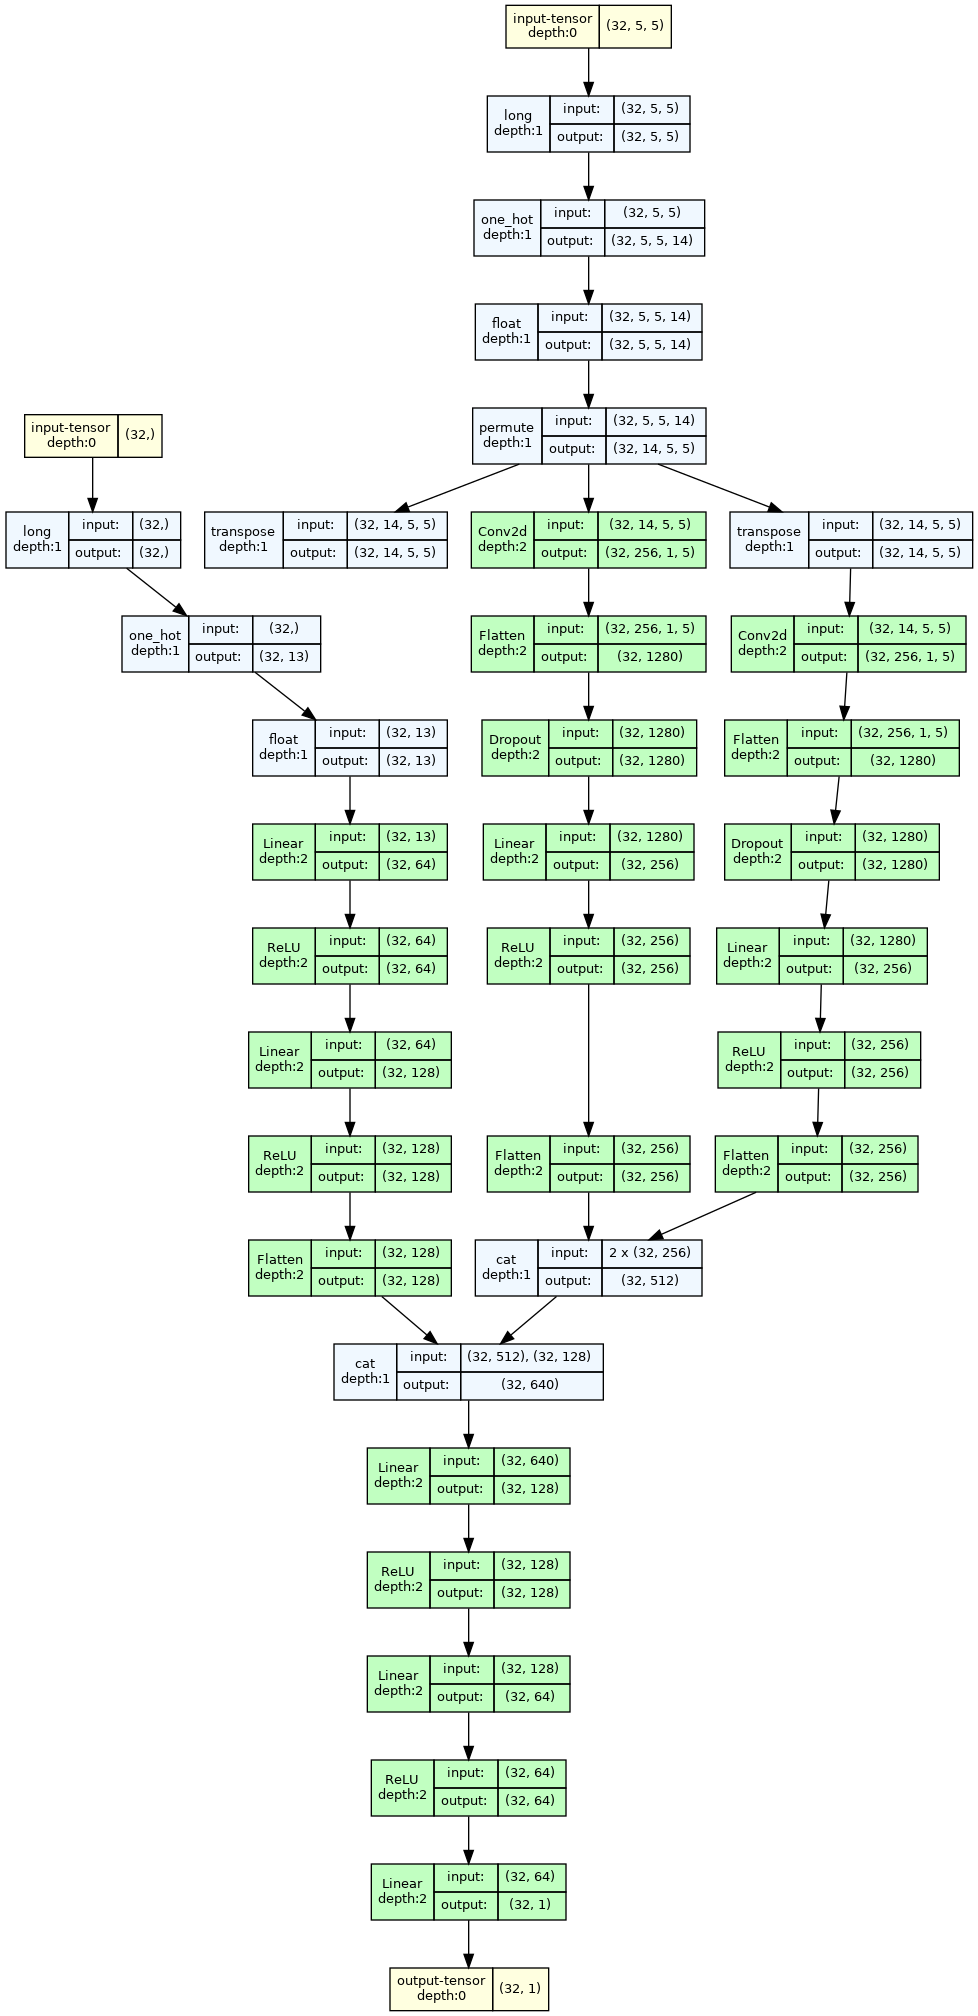

In [35]:
import torch.nn as nn
import torch.nn.functional as F


BOARD_SIZE = 5
AVAILABLE_CARDS = 13
BOARD_CARDS = AVAILABLE_CARDS + 1  # for no card


class NNv1(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # for processing the board
        self.block = nn.Sequential(
            nn.Conv2d(in_channels=BOARD_CARDS, out_channels=256, kernel_size=(5,1), padding=0),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(5 * 256, 256),
            nn.ReLU(),
            nn.Flatten(start_dim=1)
        )

        # for processing the card
        self.fc = nn.Linear(13, 64)
        self.relu = nn.ReLU()
        self.card = nn.Sequential(
            nn.Linear(AVAILABLE_CARDS, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Flatten(start_dim=1)
        )

        self.out = nn.Sequential(
            nn.Linear(2*256 + 128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, board, card):
        """
        board = torch.tensor([[1,1,1,1], [1,1,1,1], ...]) -- BATCH_SIZE, 5, 5
        card = torch.tensor(card) -- BATCH_SIZE
        """

        # Analysing the current card
        card = F.one_hot(card.long(), num_classes=AVAILABLE_CARDS).float()
        card = self.card(card)

        # The board
        board = F.one_hot(board.long(), num_classes=BOARD_CARDS).float()  
        board = board.permute(0, 3, 1, 2) # permute dimensions to match expected order
        print(f"shape = {board.shape}")

        horiz = self.block(board)
        print(f"h shape = {horiz.shape}")
        verti = self.block(board.transpose(-1, -2)) # TODO: makes sence?
        print(f"v shape = {verti.shape} from {board.transpose(-1, -2).shape}")
        #maind = self.block(board.diagonal(0, -2, -1)[:, :, :, None].transpose(-1, -2))
        #print(f"main shape = {maind.shape}")
        #antid = self.block(torch.flip(board, [-2, -1]).diagonal(0, -2, -1)[:, :, :, None])
        #print(f"anti shape = {antid.shape}")
        # TODO: sole out the convolution and apply accordingly
        board = torch.cat([horiz, verti], dim=-1)
        print(f"board shape = {board.shape}")

        together = torch.cat([board, card], dim=-1)
        out = self.out(together)
        return out


from torchview import draw_graph

# VS code fix for cropped images
import graphviz
graphviz.set_jupyter_format('png')

model = NNv1().to(dev)
BOARD = [[1] * 5] * 5
CARD = 1
BSIZE = 32

bb = [BOARD] * BSIZE
cc = [CARD] * BSIZE
bb = torch.tensor(bb).to(dev)
cc = torch.tensor(cc).to(dev)

print(f"starting with cc {cc.shape}")
print(f"starting with bb {bb.shape}")

model.forward(bb, cc)


display(draw_graph(model, input_data=(bb, cc)).visual_graph)

### Weight & Biases Initialisation

In [ ]:
%pip install -q wandb
import wandb

Note: you may need to restart the kernel to use updated packages.


In [ ]:
wandb.init(config=config, project="PA026")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /home/miso/.netrc
